In [1]:
import tensorflow as tf

In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.utils import class_weight
from keras_preprocessing import image as im
tf.random.set_seed(
    5
)

# Loading data

In [3]:
def load_data(image_path, annotations_path):
    df = pd.read_csv(annotations_path)
    df = df[~df['human_sentiment'].isna()]
    in_folder = os.listdir(image_path)
    df.loc[df['image_name'].isin(in_folder), 'image_name'] = \
    df.loc[df['image_name'].isin(in_folder), 'image_name'].apply(lambda x: os.path.join(image_path,x))
    images = []
    for image_name in df['image_name'].values:
        images.append(np.array(im.load_img(image_name, target_size=(224,224))))
    images = np.array(images)
    images = images/255
    annotations = df['annotation'].str.lower().values
    return images, annotations

In [4]:
images, annotations = load_data("../../../images/", '../../../emo-at-cap.csv')

# Processing of data

In [5]:
import nltk

In [6]:
tokenizer = nltk.tokenize.WordPunctTokenizer()

In [7]:
tokenized = [tokenizer.tokenize(i) for i in annotations]

In [8]:
unique_tokens, unique_counts = np.unique(np.hstack(tokenized), return_counts=True)

In [9]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(np.hstack(tokenized)), np.hstack(tokenized))

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=["'" ',' '-' ... 'youth' 'исходный' 'текст'], y=['the' 'man' 'is' ... 'with' 'some' 'clothes'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [10]:
frequency = sorted(list(zip(unique_tokens, unique_counts)), key = lambda x: x[1])[::-1][:50]

In [11]:
frequency

[('the', 3261),
 ('is', 2031),
 ('man', 1905),
 ('and', 1536),
 ('woman', 1361),
 ('are', 1036),
 ('a', 963),
 ('to', 891),
 ('looks', 751),
 ('happy', 705),
 ('with', 547),
 ('something', 480),
 ('men', 478),
 ('of', 463),
 ('two', 408),
 ('other', 361),
 ('people', 343),
 ('couple', 334),
 (',', 330),
 ('in', 278),
 ('look', 270),
 ('because', 265),
 ('they', 256),
 ('about', 247),
 ('on', 246),
 ('at', 192),
 ('trying', 190),
 ('serious', 189),
 ('women', 184),
 ('each', 179),
 ('together', 176),
 ('by', 175),
 ('having', 171),
 ('flirting', 165),
 ('he', 155),
 ('smiling', 151),
 ('arguing', 141),
 ('angry', 140),
 ('scared', 138),
 ('worried', 137),
 ('hugging', 135),
 ('surprised', 134),
 ('calm', 133),
 ('company', 131),
 ('her', 129),
 ('group', 123),
 ('for', 121),
 ('she', 117),
 ('looking', 117),
 ('his', 115)]

In [12]:
len(unique_tokens)

2162

In [13]:
pad_token = '<PAD>'
start_token = '<S>'
end_token = '<E>'

In [14]:
vocab = dict(zip(unique_tokens,list(range(3,len(unique_tokens)+3))))
vocab[pad_token] = 0
vocab[start_token] = 1
vocab[end_token] = 2

In [15]:
inverse_vocab = dict([(v,k) for k,v in vocab.items()])

In [16]:
add_special_tokens = lambda x: [start_token] + x + [end_token]

In [17]:
tokenized_prepared = list(map(add_special_tokens,tokenized))

In [18]:
max_len = len(max(tokenized_prepared, key=len))

In [19]:
indexed = list(map(lambda x: [vocab[i] for i in x],tokenized_prepared))

In [20]:
padded = tf.keras.preprocessing.sequence.pad_sequences(indexed, truncating='post')

In [21]:
images.shape

(3840, 224, 224, 3)

In [22]:
len(class_weights)

2162

In [23]:
class_weights = list(class_weights)
class_weights.insert(0, 1)
class_weights.insert(1, 1)
class_weights.insert(2, 1)

In [24]:
len(class_weights), len(vocab)

(2165, 2165)

In [25]:
class_weights[:4]

[1, 1, 1, 0.21013259327782918]

In [26]:
class_weights = np.array(class_weights)

In [27]:
class_weights.shape

(2165,)

# Model with transfer learning

In [28]:
def calc_size(x, f, s, padding='same'):
    p = 2 if padding=='same' else 1
    return (x-f+2)/s+1

### Convolutional model

In [29]:
import tensorflow.keras.applications as apps


In [31]:
class ConvEncoder(tf.keras.Model):
    def __init__(self, trainable=False, n_finetune=5):
        super(ConvEncoder, self).__init__()
        #building resnet
        resnet = apps.ResNet152V2(include_top=False, weights='imagenet')
        outputs = [i for i in resnet.layers if i.name=='conv4_block5_out'][0]
        inputs = resnet.layers[0]
        self.resnet_extractor = tf.keras.models.Model(inputs=inputs.input, outputs=outputs.output)
        if trainable and n_finetune:
            for layer in self.resnet_extractor.layers[:-n_finetune]:
                layer.trainable = False
        else:
            self.resnet_extractor.trainable = trainable
        
        #batch norm
        self.batch_norm1 =  tf.keras.layers.BatchNormalization()
        self.batch_norm2 =  tf.keras.layers.BatchNormalization()
        self.batch_norm3 =  tf.keras.layers.BatchNormalization()
        #dropout
        self.dropout = tf.keras.layers.Dropout(0.1)
        
        #on top extractors 
        self.conv1 = tf.keras.layers.Conv2D(filters=1024, kernel_size=7, activation='relu',
                               padding='same', name='conv1', strides=(2,2))
        self.conv2 = tf.keras.layers.Conv2D(filters=1024, kernel_size=5, activation='relu',
                                       padding='same', name='conv2', strides=(2,2))
        self.conv3 = tf.keras.layers.Conv2D(filters=512, kernel_size=4, activation='relu',
                                       padding='same', name='conv3', strides=(2,2))
        self.conv4 = tf.keras.layers.Conv2D(filters=512, kernel_size=1, activation='relu',
                                       padding='same', name='conv4', strides=(2,2))
        
        self.conv5 = tf.keras.layers.Conv2D(filters=512, kernel_size=1, activation='relu',
                                       padding='same', name='conv5', strides=(2,2))
        self.flatten = tf.keras.layers.Flatten()
        
    def call(self, input):
        resnet_features = self.resnet_extractor(input)
        conv1_out = self.batch_norm1(self.conv1(resnet_features))
        conv2_out = self.batch_norm2(self.conv2(conv1_out))
        conv3_out = self.batch_norm3(self.conv3(conv2_out))
        conv4_out = self.conv4(conv3_out)
        conv5_out = self.conv5(conv3_out)
        return [self.dropout(self.flatten(conv4_out)), self.dropout(self.flatten(conv5_out))]

In [32]:
conv_encoder = ConvEncoder(trainable=True, n_finetune=5)

In [33]:
conv_res = conv_encoder(np.expand_dims(images[0],axis=0))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [34]:
conv_res

[<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
 array([[0.02924642, 0.        , 0.        , 0.        , 0.10911995,
         0.        , 0.        , 0.18338934, 0.05146744, 0.        ,
         0.        , 0.        , 0.        , 0.16736335, 0.        ,
         0.        , 0.09801978, 0.        , 0.        , 0.        ,
         0.08093571, 0.        , 0.03379763, 0.02492007, 0.00236885,
         0.        , 0.        , 0.0740217 , 0.        , 0.04225038,
         0.04008117, 0.        , 0.        , 0.04454731, 0.16968551,
         0.        , 0.12434446, 0.        , 0.02732593, 0.22684915,
         0.14309222, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.03381285, 0.        , 0.2377917 ,
         0.        , 0.06482898, 0.12469408, 0.07052656, 0.        ,
         0.12978508, 0.12018974, 0.        , 0.09330165, 0.        ,
         0.        , 0.14704132, 0.21045415, 0.        , 0.04664548,
         0.09444183, 0.17320187, 0.26384944, 0.     

### LSTM model

### making w2v embeddings

In [35]:
!pip install gensim

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [36]:
import gensim.downloader as api

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [37]:
w2v_embeddings = api.load('word2vec-google-news-300')

In [38]:
def build_embeddings(vocab, word_vectors, embed_dim):
    emb_matrix = np.zeros(shape=(len(vocab)+ 1 , embed_dim), dtype='float32')
    count = 0
    for word, i in vocab.items():
        try:
            emb_matrix[i, :] = word_vectors.get_vector(word)
        except:
            count += 1
            emb_matrix[i, :] = np.random.uniform(-0.1, 0.1, embed_dim)
    print('{} words are out of vocabulary：'.format(count))
    return emb_matrix


In [39]:
w2v_embeddings = build_embeddings(vocab, w2v_embeddings, 300)

22 words are out of vocabulary：


### building model

In [40]:
class LSTMDecoder(tf.keras.Model):
    def __init__(self, max_tokens, lstm_units, embeddings=None, dim=128):
        super(LSTMDecoder, self).__init__()
        self.embeddings = tf.keras.layers.Embedding(input_dim=max_tokens+1, output_dim=dim, name='embeddings',
                                                   weights=[embeddings])
        self.dropout = tf.keras.layers.SpatialDropout1D(0.2)
        self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6, name='layer_normalization')
        self.lstm = tf.keras.layers.LSTM(units=lstm_units, return_state=True, name='lstm_decoder', recurrent_dropout=0.3)
        self.output_dense = tf.keras.layers.Dense(units=max_tokens)
        
    def call(self, input, features):
        embedded = self.dropout(self.embeddings(input))
        result_lstm, state_h, state_c = self.lstm(embedded, initial_state=features)
        normalized = self.layer_norm(result_lstm)
        logits = self.output_dense(normalized)
        return logits, [state_h, state_c]

In [41]:
lstm_decoder = LSTMDecoder(len(inverse_vocab), conv_res[0].shape[1], w2v_embeddings, dim=300)

In [42]:
lstm_decoder(np.expand_dims(padded[0],axis=0), conv_res)

(<tf.Tensor: shape=(1, 2165), dtype=float32, numpy=
 array([[-0.48332375,  0.5019406 ,  0.3691842 , ..., -1.5895913 ,
         -0.64764845,  0.21898055]], dtype=float32)>,
 [<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
  array([[ 5.26001453e-02, -1.69118792e-02,  2.89620887e-02,
          -1.11082438e-02, -7.93501642e-03,  1.40176034e-02,
          -1.76163949e-02,  3.23661044e-02,  9.00775660e-03,
          -1.23221921e-02,  2.11801380e-04,  9.92069114e-03,
          -1.73981730e-02,  1.21062566e-02,  2.00472809e-02,
          -2.30478309e-02,  1.84603594e-02,  8.30704230e-04,
          -1.61230415e-02,  4.10544872e-02, -2.02876721e-02,
           4.47607897e-02, -5.30215651e-02,  1.41531350e-02,
          -5.61552821e-03, -1.26754772e-02,  3.04835699e-02,
           4.41064220e-03, -1.46762142e-02,  4.11301851e-02,
           3.79293524e-02,  8.03737342e-03, -5.53493015e-02,
           3.17714140e-02,  6.05577463e-03,  2.38899188e-03,
          -4.46022581e-03, -1.51393525e-02, 

### Training

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none',
                                                                         from_logits=True)
lr_value = 1e-3
reduction_power = 10
optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_value)
with_weights = False

In [45]:
epochs = 30
batch_size = 128
patience_epochs = 2

In [46]:
def loss_function(real, pred, loss_weights):
        mask = tf.math.logical_not(tf.math.equal(real, vocab[pad_token]))
        loss_ = loss_object(real, pred)
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        loss_weights = tf.cast(loss_weights, dtype=loss_.dtype)
        loss_*=loss_weights
        return loss_

In [47]:
@tf.function
def train_step(image, target, lengths, optimizer):

    with tf.GradientTape() as tape:
        initial_state = conv_encoder(image)
        # Teacher forcing - feeding the target as the next input
        batched_loss = []
        for t in range(1, target.shape[1]):
            
            dec_input = tf.expand_dims(target[:, t-1], 1)
            result, initial_state = lstm_decoder(input=dec_input, features=initial_state)
            weights = tf.broadcast_to(class_weights, shape=(target[:,t].shape[0], class_weights.shape[0]))
            weights = tf.gather(weights, target[:,t],axis=1, batch_dims=1)
            batched_loss.append(loss_function(target[:, t], result, weights))
        batched_loss = tf.reshape(tf.stack(batched_loss), shape=target[:,1:].shape)
        batched_loss = tf.reduce_sum(batched_loss, axis=1)
        lengths = tf.cast(lengths, dtype=batched_loss.dtype)
        loss = tf.reduce_mean(batched_loss / lengths)

    perplexity = tf.exp(loss)

    variables = conv_encoder.trainable_variables + lstm_decoder.trainable_variables
    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return loss, perplexity

In [48]:
@tf.function
def evaluate(image, target, lengths, optimizer):

    initial_state = conv_encoder(image)
    # Teacher forcing - feeding the target as the next input
    batched_loss = []
    for t in range(1, target.shape[1]):

        dec_input = tf.expand_dims(target[:, t-1], 1)
        result, initial_state = lstm_decoder(input=dec_input, features=initial_state)
        weights = tf.broadcast_to(class_weights, shape=(target[:,t].shape[0], class_weights.shape[0]))
        weights = tf.gather(weights, target[:,t],axis=1, batch_dims=1)
        batched_loss.append(loss_function(target[:, t], result,weights))
    
    batched_loss = tf.reshape(tf.stack(batched_loss), shape=target[:,1:].shape)
    batched_loss = tf.reduce_sum(batched_loss, axis=1)
    lengths = tf.cast(lengths, dtype=batched_loss.dtype)
    loss = tf.reduce_mean(batched_loss / lengths)
    perplexity = tf.exp(loss)


    return loss, perplexity

In [49]:
train_images, test_images, train_sequences, test_sequences =  train_test_split(images, padded, test_size=0.1, random_state=9)

In [50]:
train_length = (train_sequences!=vocab[pad_token]).sum(axis=1)-2

In [51]:
test_length = (test_sequences!=vocab[pad_token]).sum(axis=1)-2

In [52]:
train_images = np.array(np.array_split(train_images, len(train_images)//batch_size))
test_images = np.array(np.array_split(test_images, len(test_images)//batch_size))
train_sequences = np.array(np.array_split(train_sequences, len(train_sequences)//batch_size))
test_sequences = np.array(np.array_split(test_sequences, len(test_sequences)//batch_size))
train_length = np.array(np.array_split(train_length, len(train_length)//batch_size))
test_length = np.array(np.array_split(test_length, len(test_length)//batch_size))

In [53]:
train_images.shape, train_sequences.shape, train_length.shape

((27, 128, 224, 224, 3), (27, 128, 37), (27, 128))

In [54]:
!pip install tqdm

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [55]:
if not with_weights:
    class_weights = np.array([1 for i in range(len(class_weights))])

In [56]:
from tqdm import tqdm

In [57]:
train_loss = []
train_perplexity = []
test_loss = []
test_perplexity = []
overfit_epochs = 0
for epoch in range(epochs):
    epoch_train_loss = 0
    epoch_train_perplexity = 0
    epoch_test_loss = 0
    epoch_test_perplexity = 0
    for batch_train_images, batch_train_sequences, batched_train_length in tqdm(zip(train_images,train_sequences,train_length)):
        batched_train_loss, batched_train_perplexity = train_step(batch_train_images,batch_train_sequences,batched_train_length, optimizer)
        epoch_train_loss+=batched_train_loss
        epoch_train_perplexity+=batched_train_perplexity
    epoch_train_loss = epoch_train_loss/train_images.shape[0]
    epoch_train_perplexity = epoch_train_perplexity/train_images.shape[0]
    train_loss.append(epoch_train_loss)
    train_perplexity.append(epoch_train_perplexity)
    print('Finished epoch {}; Train loss : {}; Train perplexity : {}'.format(epoch,epoch_train_loss,epoch_train_perplexity))
    for batch_test_images, batch_test_sequences, batched_test_length in zip(test_images,test_sequences,test_length):
        batched_test_loss, batched_test_perplexity = evaluate(batch_test_images,batch_test_sequences,batched_test_length, optimizer)
        epoch_test_loss+=batched_test_loss
        epoch_test_perplexity+=batched_test_perplexity
    epoch_test_loss = epoch_test_loss/test_images.shape[0]
    epoch_test_perplexity = epoch_test_perplexity/test_images.shape[0]
    test_perplexity.append(epoch_test_perplexity)
    test_loss.append(epoch_test_loss)
    print('Test loss : {}; Test perplexity : {}'.format(epoch_test_loss,epoch_test_perplexity))
    if len(test_loss)>=2 and test_loss[-2]<test_loss[-1]:
        overfit_epochs+=1
    else:
        overfit_epochs=0
    if overfit_epochs==patience_epochs:
        lr_value/=reduction_power
        optimizer.lr.assign(lr_value)
        print('There was no improvement in test loss for {} epochs, thus reducing learning rate'.format(patience_epochs))

27it [02:29,  5.53s/it]


Finished epoch 0; Train loss : 6.726306438446045; Train perplexity : 3376.342529296875


0it [00:00, ?it/s]

Test loss : 6.1749444007873535; Test perplexity : 489.4914855957031


27it [01:22,  3.06s/it]


Finished epoch 1; Train loss : 5.27034330368042; Train perplexity : 216.611328125


0it [00:00, ?it/s]

Test loss : 4.868429660797119; Test perplexity : 131.65171813964844


27it [01:23,  3.10s/it]


Finished epoch 2; Train loss : 4.324431419372559; Train perplexity : 78.20356750488281


0it [00:00, ?it/s]

Test loss : 4.299644947052002; Test perplexity : 74.7761001586914


27it [01:24,  3.13s/it]


Finished epoch 3; Train loss : 3.7572481632232666; Train perplexity : 44.37887954711914


0it [00:00, ?it/s]

Test loss : 4.0659871101379395; Test perplexity : 59.29136657714844


27it [01:25,  3.16s/it]


Finished epoch 4; Train loss : 3.440006971359253; Train perplexity : 31.848636627197266


0it [00:00, ?it/s]

Test loss : 3.8746140003204346; Test perplexity : 48.7705192565918


27it [01:28,  3.28s/it]


Finished epoch 5; Train loss : 3.196138620376587; Train perplexity : 24.85237693786621


0it [00:00, ?it/s]

Test loss : 3.880397081375122; Test perplexity : 49.00774002075195


27it [01:28,  3.28s/it]


Finished epoch 6; Train loss : 2.9826323986053467; Train perplexity : 19.96853256225586


0it [00:00, ?it/s]

Test loss : 3.823805570602417; Test perplexity : 46.398223876953125


27it [01:23,  3.11s/it]


Finished epoch 7; Train loss : 2.812933921813965; Train perplexity : 16.80807113647461


0it [00:00, ?it/s]

Test loss : 3.765131711959839; Test perplexity : 43.70442199707031


27it [01:22,  3.06s/it]


Finished epoch 8; Train loss : 2.6398987770080566; Train perplexity : 14.152265548706055


0it [00:00, ?it/s]

Test loss : 3.7647411823272705; Test perplexity : 43.684814453125


27it [01:22,  3.05s/it]


Finished epoch 9; Train loss : 2.49131178855896; Train perplexity : 12.165546417236328


0it [00:00, ?it/s]

Test loss : 3.8366823196411133; Test perplexity : 46.87786865234375


27it [01:22,  3.04s/it]


Finished epoch 10; Train loss : 2.3412508964538574; Train perplexity : 10.444001197814941


0it [00:00, ?it/s]

Test loss : 3.7217910289764404; Test perplexity : 41.83255386352539


27it [01:22,  3.04s/it]


Finished epoch 11; Train loss : 2.218362808227539; Train perplexity : 9.23667049407959


0it [00:00, ?it/s]

Test loss : 3.7622272968292236; Test perplexity : 43.440120697021484


27it [01:22,  3.04s/it]


Finished epoch 12; Train loss : 2.107008218765259; Train perplexity : 8.256625175476074


0it [00:00, ?it/s]

Test loss : 3.8461878299713135; Test perplexity : 47.35322952270508
There was no improvement in test loss for 2 epochs, thus reducing learning rate


27it [01:21,  3.04s/it]


Finished epoch 13; Train loss : 1.8804731369018555; Train perplexity : 6.6061882972717285


0it [00:00, ?it/s]

Test loss : 3.6752984523773193; Test perplexity : 39.831695556640625


27it [01:22,  3.04s/it]


Finished epoch 14; Train loss : 1.8171617984771729; Train perplexity : 6.177892208099365


0it [00:00, ?it/s]

Test loss : 3.6573925018310547; Test perplexity : 39.12544250488281


27it [01:22,  3.05s/it]


Finished epoch 15; Train loss : 1.7908737659454346; Train perplexity : 6.014473915100098


0it [00:00, ?it/s]

Test loss : 3.6435468196868896; Test perplexity : 38.58089828491211


27it [01:22,  3.05s/it]


Finished epoch 16; Train loss : 1.7685232162475586; Train perplexity : 5.87961483001709


0it [00:00, ?it/s]

Test loss : 3.637927770614624; Test perplexity : 38.36539077758789


27it [01:22,  3.04s/it]


Finished epoch 17; Train loss : 1.7485617399215698; Train perplexity : 5.76215124130249


0it [00:00, ?it/s]

Test loss : 3.6334078311920166; Test perplexity : 38.18874740600586


27it [01:21,  3.03s/it]


Finished epoch 18; Train loss : 1.7299171686172485; Train perplexity : 5.654812335968018


0it [00:00, ?it/s]

Test loss : 3.6301305294036865; Test perplexity : 38.0607795715332


27it [01:22,  3.07s/it]


Finished epoch 19; Train loss : 1.7125234603881836; Train perplexity : 5.556562423706055


0it [00:00, ?it/s]

Test loss : 3.6280717849731445; Test perplexity : 37.98063278198242


27it [01:22,  3.04s/it]


Finished epoch 20; Train loss : 1.6958376169204712; Train perplexity : 5.464054107666016


0it [00:00, ?it/s]

Test loss : 3.6267969608306885; Test perplexity : 37.929054260253906


27it [01:22,  3.07s/it]


Finished epoch 21; Train loss : 1.6801091432571411; Train perplexity : 5.378342628479004


0it [00:00, ?it/s]

Test loss : 3.62872314453125; Test perplexity : 38.00154495239258


27it [01:23,  3.11s/it]


Finished epoch 22; Train loss : 1.6684571504592896; Train perplexity : 5.315824031829834


0it [00:00, ?it/s]

Test loss : 3.6262218952178955; Test perplexity : 37.90189743041992


27it [01:24,  3.12s/it]


Finished epoch 23; Train loss : 1.6502058506011963; Train perplexity : 5.219220161437988


0it [00:00, ?it/s]

Test loss : 3.628103256225586; Test perplexity : 37.975257873535156


27it [01:23,  3.08s/it]


Finished epoch 24; Train loss : 1.6360557079315186; Train perplexity : 5.145604610443115


0it [00:00, ?it/s]

Test loss : 3.627680540084839; Test perplexity : 37.95869064331055


27it [01:31,  3.39s/it]


Finished epoch 25; Train loss : 1.6226379871368408; Train perplexity : 5.076684474945068


0it [00:00, ?it/s]

Test loss : 3.6309707164764404; Test perplexity : 38.08320999145508


27it [01:24,  3.13s/it]


Finished epoch 26; Train loss : 1.6113556623458862; Train perplexity : 5.019460678100586


0it [00:00, ?it/s]

Test loss : 3.6297943592071533; Test perplexity : 38.02646255493164


27it [01:23,  3.09s/it]


Finished epoch 27; Train loss : 1.5958058834075928; Train perplexity : 4.941821575164795


0it [00:00, ?it/s]

Test loss : 3.6319875717163086; Test perplexity : 38.114437103271484


27it [01:22,  3.05s/it]


Finished epoch 28; Train loss : 1.583735704421997; Train perplexity : 4.882404327392578


0it [00:00, ?it/s]

Test loss : 3.634873151779175; Test perplexity : 38.223697662353516
There was no improvement in test loss for 2 epochs, thus reducing learning rate


27it [01:22,  3.04s/it]


Finished epoch 29; Train loss : 1.5695332288742065; Train perplexity : 4.814998149871826
Test loss : 3.6385982036590576; Test perplexity : 38.35597610473633


# Viewing and saving results

In [58]:
df = pd.DataFrame()
model_name = 'conv_lstm_transfer_learning'
df['train_perplexity_{}'.format(model_name)] = [i.numpy() for i in train_perplexity]
df['test_perplexity_{}'.format(model_name)] = [i.numpy() for i in test_perplexity]
df['train_loss_{}'.format(model_name)] = [i.numpy() for i in train_loss]
df['test_loss_{}'.format(model_name)] = [i.numpy() for i in test_loss]
df.to_csv('{}_logs.csv'.format(model_name),index=False)

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

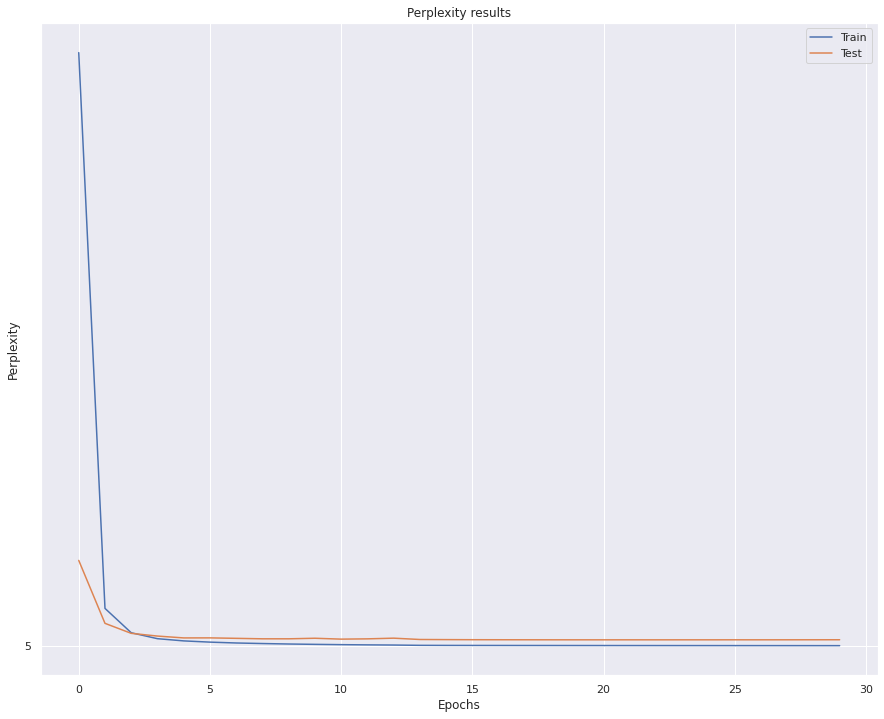

In [60]:
plt.figure(figsize=(15,12))
plt.title('Perplexity results')
plt.plot(df['train_perplexity_{}'.format(model_name)])
plt.plot(df['test_perplexity_{}'.format(model_name)])
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.yticks(np.arange(min(df['train_perplexity_{}'.format(model_name)]), max(df['train_perplexity_{}'.format(model_name)]),5000))
plt.legend(['Train', 'Test']);

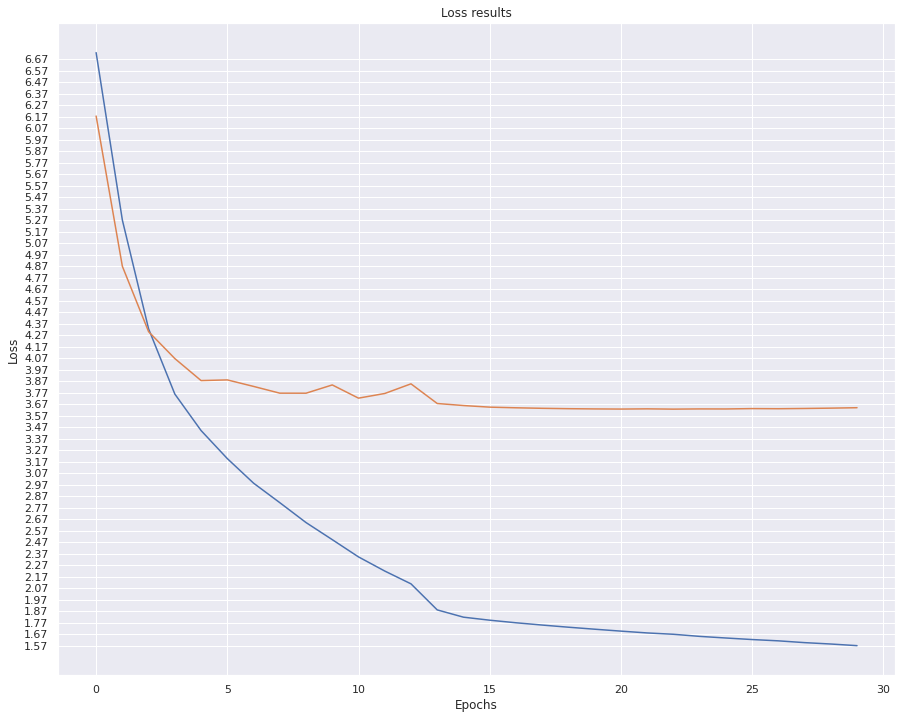

In [61]:
plt.figure(figsize=(15,12))
plt.title('Loss results')
plt.plot(df['train_loss_{}'.format(model_name)])
plt.plot(df['test_loss_{}'.format(model_name)])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yticks(np.arange(min(df['train_loss_{}'.format(model_name)]),max(df['train_loss_{}'.format(model_name)]),0.1));

# Testing model

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
class Decoder:
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10, ):
        self.encoder = encoder
        self.decoder = decoder
        self.max_len = max_len
        self.start_token = start_token
        self.end_token = end_token

    def decode(self, input):
        pass


class GreedyDecoder(Decoder):
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10,
                 ):
        super().__init__(encoder,
                         decoder,
                         start_token,
                         end_token,
                         max_len
                         )

    def decode(self, input, max_len_output=50):
        initial_state = self.encoder(np.expand_dims(input, axis=0))

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = self.start_token

        res = []
        while True:
            # Sample a token
            output, initial_state = self.decoder(target_seq,initial_state)
            sampled_token_index = np.argmax(output.numpy()[0])

            if len(res) > max_len_output or sampled_token_index == self.end_token:
                break

            res.append(sampled_token_index)

            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index

       
        return res


In [64]:
class BeamSearchDecoder(Decoder):
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10,
                 ):
        super().__init__(encoder,
                         decoder,
                         start_token,
                         end_token,
                         max_len
                         )

    def decode(self, input, beam_size=3):
        start = [self.start_token]
        initial_state = self.encoder(np.expand_dims(input,axis=0))


        start_word = [[start, 0.0, initial_state]]

        while len(start_word[0][0]) < self.max_len:
            temp = []
            for s in start_word:
                target_seq = np.array([[s[0][-1]]])
                initial_state = s[-1]
                output, initial_state= self.decoder(target_seq, initial_state)
                output = np.hstack(output)
                output = tf.nn.softmax(output).numpy()
                word_preds = np.argsort(output)[-beam_size:]

                for w in word_preds:
                    next_cap, prob = s[0][:], s[1]
                    next_cap.append(w)
                    prob += output[w]
                    temp.append([next_cap, prob, initial_state])

            start_word = temp
            # Sorting according to the probabilities
            start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
            # Getting the top words
            start_word = start_word[-beam_size:]

        start_word = start_word[-1][0]

        final_caption = []

        for i in start_word:
            if i != self.end_token:
                final_caption.append(i)
            else:
                break
        return final_caption[1:]

In [65]:
def predict(data, decoder, inverse_vocab,
           beam_size=None):
    if beam_size:
        result = decoder.decode(data, beam_size=beam_size)
    else:
        result = decoder.decode(data)
    return ' '.join([inverse_vocab[i] for i in result])

In [66]:
greedy_decoder = GreedyDecoder(conv_encoder, lstm_decoder, vocab[start_token], vocab[end_token],
             max_len=39)

In [67]:
beam_decoder = BeamSearchDecoder(conv_encoder, lstm_decoder, vocab[start_token], vocab[end_token],
             max_len=39)

In [68]:
images.shape

(3840, 224, 224, 3)

In [77]:
idx = np.random.choice(range(len(images)))
sample = images[idx]

women are mysterious and flirty smiling


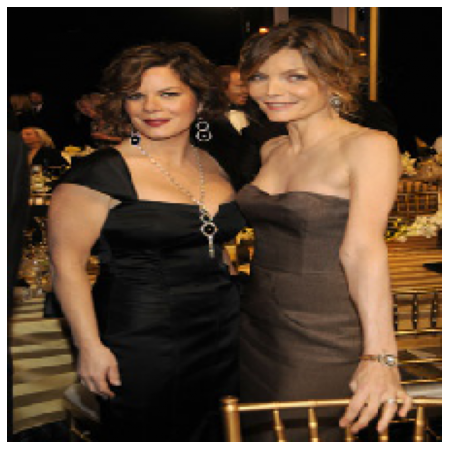

In [78]:
plt.figure(figsize=(8,8))
plt.imshow(sample)
plt.grid([])
plt.axis('off');
print(annotations[idx])

In [79]:
predict(sample, greedy_decoder, inverse_vocab)

'laughs woman laughs a woman laughs because she takes part in a traditional or national custom and a man looks a bit confused because he is up the strange , but with a man looks confident and'

In [80]:
predict(sample, beam_decoder, inverse_vocab, beam_size=3)

"laughs woman laughs as she takes part in some traditional or national custom and a man behind the screams with joy because he is going to give up the beach and doesn ' t pay attention"

# Blue score calculation

In [92]:
from nltk.translate.bleu_score import sentence_bleu


### making predictions on test dataset with beam_size of 5

In [105]:
test_predictions = []
for batch in tqdm(test_images):
    for image in batch:
        result = predict(image, beam_decoder, inverse_vocab, beam_size=5)
        test_predictions.append(result)

100%|██████████| 6/6 [13:56<00:00, 139.41s/it]


In [111]:
test_predictions = [i.split(' ') for i in test_predictions]

In [107]:
reshaped_sequences = test_sequences.reshape(test_sequences.shape[0]*test_sequences.shape[1],-1)

In [108]:
test_sentences = []
for i in reshaped_sequences:
    tmp = []
    for word in i:
        if word!=0 and word!=1 and word!=2:
            tmp.append(inverse_vocab[word])
    test_sentences.append(tmp)

In [115]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu(reference, prediction,weights=(0.5, 0.5)))
print('Bleu score on test data : {}'.format(np.mean(bleu_score)))

Bleu score on test data : 4.2958840740224755e-156


### making predictions on test dataset with beam_size of 10

In [ ]:
test_predictions = []
for batch in tqdm(test_images):
    for image in batch:
        result = predict(image, beam_decoder, inverse_vocab, beam_size=10)
        test_predictions.append(result)

In [ ]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu(reference, prediction))
print('Bleu score on test data : {}'.format(np.mean(bleu_score)))